In [1]:
import pickle
import pandas as pd
import requests
import time
import json
from glob import glob

In [3]:
dskey = pickle.load(open("darkskyapi.p",'rb'))
open("darkskyapi.p",'rb').close

date_vars = ['Date']
air_df = []
for file in glob('ozone data by year/*.csv'):
    air_df.append(pd.read_csv(file, parse_dates=date_vars, date_parser=pd.to_datetime))


air_df = pd.concat(air_df)
air_df.shape

(3091, 20)

dark sky single test

In [ ]:
# long = air_df.iloc[299,-1]

# lat =air_df.iloc[299,-2]

# day = air_df.iloc[298,0]


# day = int(time.mktime(day.timetuple()))
# url ='https://api.darksky.net/forecast/'+dskey+'/'+str(lat)+','+str(long)+','+str(day)
# weather= requests.get(url)
# weather.json()['daily']['data'][0]

In [4]:
# day_length =[]
# temp_high =[]
# temp_low =[]
# dew_point =[]
# humidity =[]
# pressure =[]
# wind_speed =[]
# wind_bearing =[]
# cloud_cover =[]
# uv_index =[]

# for i in range(air_df.shape[0]):
#     try:
#         long = air_df.iloc[i,-1]
#         lat =air_df.iloc[i,-2]
#         day = air_df.iloc[i,0]
#         day = pd.to_datetime(day , format ='%m/%d/%Y')
#         day = int(time.mktime(day.timetuple()))
#         url ='https://api.darksky.net/forecast/'+dskey+'/'+str(lat)+','+str(long)+','+str(day)
#         weather= requests.get(url)
#         day_length.append(weather.json()['daily']['data'][0]['sunsetTime'] - weather.json()['daily']['data'][0]['sunriseTime'])
#         try:
#             temp_high.append(weather.json()['daily']['data'][0]['temperatureHigh'])
#         except:
#             temp_high.append(weather.json()['daily']['data'][0]['temperatureMax'])
#         try:
#             temp_low.append(weather.json()['daily']['data'][0]['temperatureLow'])
#         except:
#             temp_low.append(weather.json()['daily']['data'][0]['temperatureMin'])
#         dew_point.append(weather.json()['daily']['data'][0]['dewPoint'])
#         humidity.append(weather.json()['daily']['data'][0]['humidity'])
#         pressure.append(weather.json()['daily']['data'][0]['pressure'])
#         wind_speed.append(weather.json()['daily']['data'][0]['windSpeed'])
#         wind_bearing.append(weather.json()['daily']['data'][0]['windBearing'])
#         cloud_cover.append(weather.json()['daily']['data'][0]['cloudCover'])
#         uv_index.append(weather.json()['daily']['data'][0]['uvIndex'])
#     except:
#         print('broken at: ' +str(i))

    

In [5]:
# air_df['day_length'] = day_length
# air_df['temp_high'] = temp_high
# air_df['temp_low'] = temp_low
# air_df['dew_point'] = dew_point
# air_df['humidity'] = humidity
# air_df['pressure'] = pressure
# air_df['wind_speed'] = wind_speed
# air_df['wind_bearing'] = wind_bearing
# air_df['cloud_cover'] = cloud_cover
# air_df['uv_index'] = uv_index

In [6]:
# pickle.dump(air_df, open('air_df_1.p','wb'))

In [7]:
air_df = pickle.load(open("air_df_1.p",'rb'))
open('air_df_1.p','rb').close

<function BufferedReader.close>

In [8]:
air_df.columns

Index(['Date', 'Source', 'Site ID', 'POC',
       'Daily Max 8-hour Ozone Concentration', 'UNITS', 'DAILY_AQI_VALUE',
       'Site Name', 'DAILY_OBS_COUNT', 'PERCENT_COMPLETE',
       'AQS_PARAMETER_CODE', 'AQS_PARAMETER_DESC', 'CBSA_CODE', 'CBSA_NAME',
       'STATE_CODE', 'STATE', 'COUNTY_CODE', 'COUNTY', 'SITE_LATITUDE',
       'SITE_LONGITUDE', 'day_length', 'temp_high', 'temp_low', 'dew_point',
       'humidity', 'pressure', 'wind_speed', 'wind_bearing', 'cloud_cover',
       'uv_index'],
      dtype='object')

In [9]:
df =air_df[['Date','Daily Max 8-hour Ozone Concentration']]

In [10]:
df.set_index('Date',inplace=True)

In [11]:
from pathlib import Path
import pandas as pd
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

Using TensorFlow backend.


In [12]:
train = df.query('Date < "2018-07-01"')
valid = df.query('Date >= "2018-07-01" and Date < "2018-11-01"')
test = df.query('Date >= "2018-11-02"')

In [13]:
# Save column names and indices to use when storing as csv
cols = train.columns
train_idx = train.index
valid_idx = valid.index
test_idx = test.index

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
valid = scaler.transform(valid)
test = scaler.transform(test)

In [14]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [15]:
n_lag = 14

train_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
valid_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen = TimeseriesGenerator(test, test, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)

Epoch 1/100
 - 8s - loss: 0.0780 - val_loss: 0.0622
Epoch 2/100
 - 9s - loss: 0.0603 - val_loss: 0.0588
Epoch 3/100
 - 9s - loss: 0.0597 - val_loss: 0.0580
Epoch 4/100
 - 10s - loss: 0.0595 - val_loss: 0.0630
Epoch 5/100
 - 9s - loss: 0.0595 - val_loss: 0.0605
Epoch 6/100
 - 10s - loss: 0.0593 - val_loss: 0.0593
Epoch 7/100
 - 10s - loss: 0.0588 - val_loss: 0.0586
Epoch 8/100
 - 9s - loss: 0.0590 - val_loss: 0.0588
Epoch 9/100
 - 10s - loss: 0.0587 - val_loss: 0.0604
Epoch 10/100
 - 10s - loss: 0.0584 - val_loss: 0.0606
Epoch 11/100
 - 10s - loss: 0.0589 - val_loss: 0.0577
Epoch 12/100
 - 10s - loss: 0.0587 - val_loss: 0.0575
Epoch 13/100
 - 10s - loss: 0.0587 - val_loss: 0.0588
Epoch 14/100
 - 10s - loss: 0.0589 - val_loss: 0.0569
Epoch 15/100
 - 10s - loss: 0.0584 - val_loss: 0.0604
Epoch 16/100
 - 10s - loss: 0.0587 - val_loss: 0.0583
Epoch 17/100
 - 11s - loss: 0.0587 - val_loss: 0.0572
Epoch 18/100
 - 11s - loss: 0.0587 - val_loss: 0.0573
Epoch 19/100
 - 10s - loss: 0.0584 - val_l

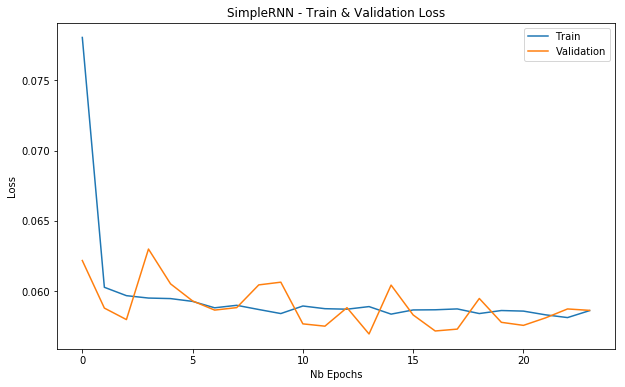

Minimum validation loss of 0.05694205285086661 reached at epoch 13


In [16]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(5, input_shape=(n_lag, 1)))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='simple_rnn_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("simple_rnn.json", "w") as m:
     m.write(simple_rnn.to_json())

simple_rnn_history = simple_rnn.fit_generator(train_data_gen
                                              , epochs=100
                                              , validation_data=valid_data_gen
                                              , verbose=2
                                              , callbacks= [checkpointer ,earlystopper])
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

In [ ]:
simple_lstm = Sequential()
simple_lstm.add(LSTM(5, input_shape=(n_lag, 1)))
simple_lstm.add(Dense(1))
simple_lstm.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='simple_lstm_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("simple_lstm.json", "w") as m:
    m.write(simple_lstm.to_json())

simple_lstm_history = simple_lstm.fit_generator(train_data_gen
                                                , epochs=100
                                                , validation_data=valid_data_gen
                                                , verbose=2                                           
                                                , callbacks=[checkpointer, earlystopper])
plot_loss(simple_lstm_history, 'Simple LSTM - Train & Validation Loss')

Epoch 1/100
 - 35s - loss: 0.0644 - val_loss: 0.0632
Epoch 2/100
 - 34s - loss: 0.0620 - val_loss: 0.0593
Epoch 3/100
 - 35s - loss: 0.0599 - val_loss: 0.0578
Epoch 4/100
 - 35s - loss: 0.0588 - val_loss: 0.0587
Epoch 5/100
 - 35s - loss: 0.0584 - val_loss: 0.0584
Epoch 6/100
 - 39s - loss: 0.0584 - val_loss: 0.0587
Epoch 7/100


In [ ]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(16, input_shape=(n_lag, 1), return_sequences=True))
stacked_lstm.add(LSTM(8, return_sequences=True))
stacked_lstm.add(LSTM(4))
stacked_lstm.add(Dense(1))
stacked_lstm.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='stacked_lstm_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("stacked_lstm.json", "w") as m:
    m.write(stacked_lstm.to_json())

stacked_lstm_history = stacked_lstm.fit_generator(train_data_gen
                                                  , epochs=100
                                                  , validation_data=valid_data_gen
                                                  , verbose=2
                                                  , callbacks=[checkpointer, earlystopper])
plot_loss(stacked_lstm_history, 'Stacked LSTM - Train & Validation Loss')

In [ ]:
df['day_length'] = day_length
df['temp_high'] = temp_high
df['temp_low'] = temp_low
df['dew_point'] = dew_point
df['humidity'] = humidity
df['pressure'] = pressure
df['wind_speed'] = wind_speed
df['wind_bearing'] = wind_bearing
df['cloud_cover'] = cloud_cover
df['uv_index'] = uv_index

In [ ]:
pickle.dump(df,open('ts_with_weather.p', 'wb'))